In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

import os
import pickle
import matplotlib.pyplot as plt
import neurokit2 as nk
import seaborn as sns
import torch
import random

from datetime import datetime
from scipy.io import savemat

In [2]:
def WESAD(LOO_dir, pretrain=True, test=False):
    #LOO_dir = f"/projappl/project_2014260/data/LOO/LOO1"
    WESAD_dir = f"/scratch/project_2014260/WESAD"
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        
        print(f"Reading data {subject_id}")
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = f'{WESAD_dir}/{subject_id}/'
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        quest = pd.read_csv(f'{data_dir}{subject_id}_quest.csv', header=None, sep=';')
        base = [float(quest.iloc[2, 1]), float(quest.iloc[3, 1])]
        tsst = [float(quest.iloc[2, 2]), float(quest.iloc[3, 2])]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
    
        # Extract start times and sampling frequencies
        start_times = [
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ]
        sampling_freqs = [
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ]
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
    
        # Select indices for baseline and stress
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
    
        processed_data = np.array(processed_data)
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')
    
            # Test set save
            _test = user_data[:len(user_data)//4]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
    
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
            
        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
        
    


In [3]:
def WDD(LOO_dir, pretrain=True, test=False):
    directory = f"/scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/"
    file_to_find = 'ACC.csv'
    subid = 0
    isfinetune = False
    for root, dirs, files in os.walk(directory):
        isfinetune = True if subid<3 else False
        subject_id = 'subject'+str(subid)
        if file_to_find in files:
            if root[-3] != 'S':
                continue
            #print(root,dirs,files)
            print(f"Reading data {subject_id}",root)
            acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
            data_dir = root
            files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        
            # Read the correct files
            for file in files:
                path = os.path.join(data_dir, file)
                if file.endswith('ACC.csv'):
                    acc_raw = pd.read_csv(path, header=None)
                elif file.endswith('BVP.csv'):
                    bvp_raw = pd.read_csv(path, header=None)
                elif file.endswith('HR.csv'):
                    hr_raw = pd.read_csv(path, header=None)
                elif file.endswith('EDA.csv'):
                    eda_raw = pd.read_csv(path, header=None)
                elif file.endswith('TEMP.csv'):
                    temp_raw = pd.read_csv(path, header=None)
                elif file.endswith('tags.csv'):
                    tags_info = pd.read_csv(path, header=None)
            tags = tags_info.iloc[:,0].to_list()
            
            if ':' in str(acc_raw.iloc[0, 0]):
                acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
                bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
            
            
            # Extract start times and sampling frequencies
            start_times = np.array([
                acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
                bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
            ], dtype=float)
            sampling_freqs = np.array([
                acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
                bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
            ], dtype=float)
            max_start = int(np.max(start_times))
            max_freq = np.max(sampling_freqs)
        
            all_data = [
                acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
                bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
            ]
            min_endtime = int(np.min([
                np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
                for d, st, sf in zip(all_data, start_times, sampling_freqs)
            ]))
        
            # Re-align, repeat upsample, crop data
            processed_data = []
            bvp_time_series = []
            for idx, data in enumerate(all_data):
                sample_rate = sampling_freqs[idx]
                start = start_times[idx]
                stop = start + len(data) / sample_rate
                time_series = np.linspace(start, stop, num=len(data))
                repeat_val = int(max_freq / sample_rate)
                data_repeated = np.repeat(data.values, repeat_val)
                ts_repeated = np.repeat(time_series, repeat_val)
                mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
                df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
                if idx == 3:  # BVP for time index
                    bvp_time_series = df['time_series'].to_numpy()
                processed_data.append(df['data'].to_numpy())
        
            
            # Select indices for baseline and stress
            print(tags[0],bvp_time_series[0])
            #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
            base = [tags[1], tags[2]]
            tsst = [tags[2], tags[3]]
            baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
            stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
            #conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
            conditions = [[ idx for idx in range(int(len(bvp_time_series)/2))], 
                            [ idx+int(len(bvp_time_series)/2) for idx in range(int(len(bvp_time_series)/2))] ]
        
            #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
            
            processed_data = np.array(processed_data)
        
            DATAS, LABELS = [], []
            window_len = 512
        
            #indices = [i for i in range(len(processed_data[0]))]
            for con_idx, indices in enumerate(conditions):
                user_data = [
                    [
                        processed_data[0][indices][i:i+window_len].tolist(),
                        processed_data[1][indices][i:i+window_len].tolist(),
                        processed_data[2][indices][i:i+window_len].tolist(),
                        processed_data[3][indices][i:i+window_len].tolist(),
                        processed_data[4][indices][i:i+window_len].tolist(),
                        processed_data[5][indices][i:i+window_len].tolist(),
                        processed_data[6][indices][i:i+window_len].tolist(),
                    ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                    for i in range(0, len(indices), window_len)
                    if min([
                        len(processed_data[c][indices][i:i+window_len])
                        for c in range(7)
                    ]) == window_len  # only if all modalities have the full window
                ]
        
                # Pretrain save
                for _d in user_data[:len(user_data)//4]:
                    dst = f"{LOO_dir}/full/"
                    dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                    os.makedirs(dst, exist_ok=True)
                    if pretrain and not isfinetune:
                        torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')
                
                # Test set
                _test = user_data[:len(user_data)//4]
                _labels = [con_idx]*len(_test)
                DATAS.extend(_test)
                LABELS.extend(_labels)
                
            DATAS = np.array(DATAS, dtype=np.float32)
            LABELS = np.array([LABELS])
            os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
            save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
            if test:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

            os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
            save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
            if pretrain and isfinetune:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
            
            subid+=1

In [4]:
def WDD1(LOO_dir, pretrain=True, test=False):
    directory = f"/scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/"
    file_to_find = 'ACC.csv'
    subid = 0
    isfinetune = False
    for root, dirs, files in os.walk(directory):
        isfinetune = True if subid<3 else False
        subject_id = 'subject'+str(subid)
        if file_to_find in files:
            if root[-3] != 'f':
                continue
            #print(root,dirs,files)
            print(f"Reading data {subject_id}",root)
            acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
            data_dir = root
            files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        
            # Read the correct files
            for file in files:
                path = os.path.join(data_dir, file)
                if file.endswith('ACC.csv'):
                    acc_raw = pd.read_csv(path, header=None)
                elif file.endswith('BVP.csv'):
                    bvp_raw = pd.read_csv(path, header=None)
                elif file.endswith('HR.csv'):
                    hr_raw = pd.read_csv(path, header=None)
                elif file.endswith('EDA.csv'):
                    eda_raw = pd.read_csv(path, header=None)
                elif file.endswith('TEMP.csv'):
                    temp_raw = pd.read_csv(path, header=None)
                elif file.endswith('tags.csv'):
                    tags_info = pd.read_csv(path, header=None)
            tags = tags_info.iloc[:,0].to_list()
            
            if ':' in str(acc_raw.iloc[0, 0]):
                acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
                bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
            
            
            # Extract start times and sampling frequencies
            start_times = np.array([
                acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
                bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
            ], dtype=float)
            sampling_freqs = np.array([
                acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
                bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
            ], dtype=float)
            max_start = int(np.max(start_times))
            max_freq = np.max(sampling_freqs)
        
            all_data = [
                acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
                bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
            ]
            min_endtime = int(np.min([
                np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
                for d, st, sf in zip(all_data, start_times, sampling_freqs)
            ]))
        
            # Re-align, repeat upsample, crop data
            processed_data = []
            bvp_time_series = []
            for idx, data in enumerate(all_data):
                sample_rate = sampling_freqs[idx]
                start = start_times[idx]
                stop = start + len(data) / sample_rate
                time_series = np.linspace(start, stop, num=len(data))
                repeat_val = int(max_freq / sample_rate)
                data_repeated = np.repeat(data.values, repeat_val)
                ts_repeated = np.repeat(time_series, repeat_val)
                mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
                df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
                if idx == 3:  # BVP for time index
                    bvp_time_series = df['time_series'].to_numpy()
                processed_data.append(df['data'].to_numpy())
        
            # Select indices for baseline and stress
            print(tags[0],bvp_time_series[0])
            #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
            base = [tags[0], tags[1]]
            tsst = [tags[1], tags[2]]
            baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
            stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
            #conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
            conditions = [[ idx for idx in range(int(len(bvp_time_series)/2))], 
                            [ idx+int(len(bvp_time_series)/2) for idx in range(int(len(bvp_time_series)/2))] ]
        
            #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
            
            processed_data = np.array(processed_data)
        
            DATAS, LABELS = [], []
            window_len = 512
        
            #indices = [i for i in range(len(processed_data[0]))]
            for con_idx, indices in enumerate(conditions):
                user_data = [
                    [
                        processed_data[0][indices][i:i+window_len].tolist(),
                        processed_data[1][indices][i:i+window_len].tolist(),
                        processed_data[2][indices][i:i+window_len].tolist(),
                        processed_data[3][indices][i:i+window_len].tolist(),
                        processed_data[4][indices][i:i+window_len].tolist(),
                        processed_data[5][indices][i:i+window_len].tolist(),
                        processed_data[6][indices][i:i+window_len].tolist(),
                    ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                    for i in range(0, len(indices), window_len)
                    if min([
                        len(processed_data[c][indices][i:i+window_len])
                        for c in range(7)
                    ]) == window_len  # only if all modalities have the full window
                ]
        
                # Pretrain save
                for _d in user_data[:len(user_data)//4]:
                    dst = f"{LOO_dir}/full/"
                    dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                    os.makedirs(dst, exist_ok=True)
                    if pretrain and not isfinetune:
                        torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')
                
                # Test set
                _test = user_data[:len(user_data)//4]
                _labels = [con_idx]*len(_test)
                DATAS.extend(_test)
                LABELS.extend(_labels)
                
            DATAS = np.array(DATAS, dtype=np.float32)
            LABELS = np.array([LABELS])
            os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
            save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
            if test:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

            os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
            save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
            if pretrain and isfinetune:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
                
            subid+=1

In [5]:
def SPD(LOO_dir, pretrain=True, test=False):
    directory = f"/scratch/project_2014260/Stress-Predict-Dataset/Raw_data/"
    file_to_find = 'ACC.csv'
    subid = 0
    isfinetune = False
    for root, dirs, files in os.walk(directory):
        isfinetune = True if subid<3 else False
        if 'S0' not in root[-3:]:
            continue
        subject_id = 'subject'+str(subid)
        if file_to_find in files:
            print(root,dirs,files)
            print(f"Reading data {subject_id}",root)
            acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
            data_dir = root
            files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        
            # Read the correct files
            for file in files:
                path = os.path.join(data_dir, file)
                if file.endswith('ACC.csv'):
                    acc_raw = pd.read_csv(path, header=None)
                elif file.endswith('BVP.csv'):
                    bvp_raw = pd.read_csv(path, header=None)
                elif file.endswith('HR.csv'):
                    hr_raw = pd.read_csv(path, header=None)
                elif file.endswith('EDA.csv'):
                    eda_raw = pd.read_csv(path, header=None)
                elif file.endswith('TEMP.csv'):
                    temp_raw = pd.read_csv(path, header=None)
                elif file.endswith(f'tags_{root[-3:]}.csv'):
                    tags_info = pd.read_csv(path, header=None)
            tags = tags_info.iloc[:,0].to_list()
            #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
            
            if ':' in str(acc_raw.iloc[0, 0]):
                acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
                bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
            
            
            # Extract start times and sampling frequencies
            start_times = np.array([
                acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
                bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
            ], dtype=float)
            sampling_freqs = np.array([
                acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
                bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
            ], dtype=float)
            max_start = int(np.max(start_times))
            max_freq = np.max(sampling_freqs)
        
            all_data = [
                acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
                bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
            ]
            min_endtime = int(np.min([
                np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
                for d, st, sf in zip(all_data, start_times, sampling_freqs)
            ]))
        
            # Re-align, repeat upsample, crop data
            processed_data = []
            bvp_time_series = []
            for idx, data in enumerate(all_data):
                sample_rate = sampling_freqs[idx]
                start = start_times[idx]
                stop = start + len(data) / sample_rate
                time_series = np.linspace(start, stop, num=len(data))
                repeat_val = int(max_freq / sample_rate)
                data_repeated = np.repeat(data.values, repeat_val)
                ts_repeated = np.repeat(time_series, repeat_val)
                mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
                df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
                if idx == 3:  # BVP for time index
                    bvp_time_series = df['time_series'].to_numpy()
                processed_data.append(df['data'].to_numpy())
        
            
            # Select indices for baseline and stress
            print(tags[0],bvp_time_series[0])
            #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
            base = [tags[-6], tags[-5]]
            tsst = [tags[0], tags[1]]
            baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
            stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
            conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
        
            #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
            
            processed_data = np.array(processed_data)
        
            full_idx = 0
            DATAS, LABELS = [], []
            window_len = 512
        
            #indices = [i for i in range(len(processed_data[0]))]
            for con_idx, indices in enumerate(conditions):
                user_data = [
                    [
                        processed_data[0][indices][i:i+window_len].tolist(),
                        processed_data[1][indices][i:i+window_len].tolist(),
                        processed_data[2][indices][i:i+window_len].tolist(),
                        processed_data[3][indices][i:i+window_len].tolist(),
                        processed_data[4][indices][i:i+window_len].tolist(),
                        processed_data[5][indices][i:i+window_len].tolist(),
                        processed_data[6][indices][i:i+window_len].tolist(),
                    ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                    for i in range(0, len(indices), window_len)
                    if min([
                        len(processed_data[c][indices][i:i+window_len])
                        for c in range(7)
                    ]) == window_len  # only if all modalities have the full window
                ]
        
                # Pretrain save
                for _d in user_data[:len(user_data)//4]:
                    dst = f"{LOO_dir}/full/"
                    dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                    os.makedirs(dst, exist_ok=True)
                    if pretrain and not isfinetune:
                        torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

                # Test set
                _test = user_data[:len(user_data)//4]
                _labels = [con_idx]*len(_test)
                DATAS.extend(_test)
                LABELS.extend(_labels)
                
            DATAS = np.array(DATAS, dtype=np.float32)
            LABELS = np.array([LABELS])
            os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
            save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
            if test:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

            os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
            save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
            if pretrain and isfinetune:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
                
            subid+=1
            

In [6]:
def SPD1(LOO_dir, pretrain=True, test=False):
    directory = f"/scratch/project_2014260/Stress-Predict-Dataset/Raw_data/"
    file_to_find = 'ACC.csv'
    subid = 0
    isfinetune = False
    for root, dirs, files in os.walk(directory):
        isfinetune = True if subid<3 else False
        if 'S1' not in root[-3:]:
            continue
        subject_id = 'subject'+str(subid)
        if file_to_find in files:
            print(root,dirs,files)
            print(f"Reading data {subject_id}",root)
            acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
            data_dir = root
            files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        
            # Read the correct files
            for file in files:
                path = os.path.join(data_dir, file)
                if file.endswith('ACC.csv'):
                    acc_raw = pd.read_csv(path, header=None)
                elif file.endswith('BVP.csv'):
                    bvp_raw = pd.read_csv(path, header=None)
                elif file.endswith('HR.csv'):
                    hr_raw = pd.read_csv(path, header=None)
                elif file.endswith('EDA.csv'):
                    eda_raw = pd.read_csv(path, header=None)
                elif file.endswith('TEMP.csv'):
                    temp_raw = pd.read_csv(path, header=None)
                elif file.endswith(f'tags_{root[-3:]}.csv'):
                    tags_info = pd.read_csv(path, header=None)
            tags = tags_info.iloc[:,0].to_list()
            #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
            
            if ':' in str(acc_raw.iloc[0, 0]):
                acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
                bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
            
            
            # Extract start times and sampling frequencies
            start_times = np.array([
                acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
                bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
            ], dtype=float)
            sampling_freqs = np.array([
                acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
                bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
            ], dtype=float)
            max_start = int(np.max(start_times))
            max_freq = np.max(sampling_freqs)
        
            all_data = [
                acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
                bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
            ]
            min_endtime = int(np.min([
                np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
                for d, st, sf in zip(all_data, start_times, sampling_freqs)
            ]))
        
            # Re-align, repeat upsample, crop data
            processed_data = []
            bvp_time_series = []
            for idx, data in enumerate(all_data):
                sample_rate = sampling_freqs[idx]
                start = start_times[idx]
                stop = start + len(data) / sample_rate
                time_series = np.linspace(start, stop, num=len(data))
                repeat_val = int(max_freq / sample_rate)
                data_repeated = np.repeat(data.values, repeat_val)
                ts_repeated = np.repeat(time_series, repeat_val)
                mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
                df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
                if idx == 3:  # BVP for time index
                    bvp_time_series = df['time_series'].to_numpy()
                processed_data.append(df['data'].to_numpy())
        
            
            # Select indices for baseline and stress
            print(tags[0],bvp_time_series[0])
            #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
            base = [tags[-6], tags[-5]]
            tsst = [tags[0], tags[1]]
            baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
            stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
            conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
        
            #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
            
            processed_data = np.array(processed_data)
        
            full_idx = 0
            DATAS, LABELS = [], []
            window_len = 512
        
            #indices = [i for i in range(len(processed_data[0]))]
            for con_idx, indices in enumerate(conditions):
                user_data = [
                    [
                        processed_data[0][indices][i:i+window_len].tolist(),
                        processed_data[1][indices][i:i+window_len].tolist(),
                        processed_data[2][indices][i:i+window_len].tolist(),
                        processed_data[3][indices][i:i+window_len].tolist(),
                        processed_data[4][indices][i:i+window_len].tolist(),
                        processed_data[5][indices][i:i+window_len].tolist(),
                        processed_data[6][indices][i:i+window_len].tolist(),
                    ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                    for i in range(0, len(indices), window_len)
                    if min([
                        len(processed_data[c][indices][i:i+window_len])
                        for c in range(7)
                    ]) == window_len  # only if all modalities have the full window
                ]
        
                # Pretrain save
                for _d in user_data[:len(user_data)//4]:
                    dst = f"{LOO_dir}/full/"
                    dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                    os.makedirs(dst, exist_ok=True)
                    if pretrain and not isfinetune:
                        torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

                # Test set
                _test = user_data[:len(user_data)//4]
                _labels = [con_idx]*len(_test)
                DATAS.extend(_test)
                LABELS.extend(_labels)
                
            DATAS = np.array(DATAS, dtype=np.float32)
            LABELS = np.array([LABELS])
            os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
            save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
            if test:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

            os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
            save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
            if pretrain and isfinetune:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
                
            subid+=1
            

In [7]:
def SPD2(LOO_dir, pretrain=True, test=False):
    directory = f"/scratch/project_2014260/Stress-Predict-Dataset/Raw_data/"
    file_to_find = 'ACC.csv'
    subid = 0
    isfinetune = False
    for root, dirs, files in os.walk(directory):
        isfinetune = True if subid<3 else False
        if 'S2' not in root[-3:]:
            continue
        subject_id = 'subject'+str(subid)
        if file_to_find in files:
            print(root,dirs,files)
            print(f"Reading data {subject_id}",root)
            acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
            data_dir = root
            files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        
            # Read the correct files
            for file in files:
                path = os.path.join(data_dir, file)
                if file.endswith('ACC.csv'):
                    acc_raw = pd.read_csv(path, header=None)
                elif file.endswith('BVP.csv'):
                    bvp_raw = pd.read_csv(path, header=None)
                elif file.endswith('HR.csv'):
                    hr_raw = pd.read_csv(path, header=None)
                elif file.endswith('EDA.csv'):
                    eda_raw = pd.read_csv(path, header=None)
                elif file.endswith('TEMP.csv'):
                    temp_raw = pd.read_csv(path, header=None)
                elif file.endswith(f'tags_{root[-3:]}.csv'):
                    tags_info = pd.read_csv(path, header=None)
            tags = tags_info.iloc[:,0].to_list()
            #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
            
            if ':' in str(acc_raw.iloc[0, 0]):
                acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
                bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
            
            
            # Extract start times and sampling frequencies
            start_times = np.array([
                acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
                bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
            ], dtype=float)
            sampling_freqs = np.array([
                acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
                bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
            ], dtype=float)
            max_start = int(np.max(start_times))
            max_freq = np.max(sampling_freqs)
        
            all_data = [
                acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
                bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
            ]
            min_endtime = int(np.min([
                np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
                for d, st, sf in zip(all_data, start_times, sampling_freqs)
            ]))
        
            # Re-align, repeat upsample, crop data
            processed_data = []
            bvp_time_series = []
            for idx, data in enumerate(all_data):
                sample_rate = sampling_freqs[idx]
                start = start_times[idx]
                stop = start + len(data) / sample_rate
                time_series = np.linspace(start, stop, num=len(data))
                repeat_val = int(max_freq / sample_rate)
                data_repeated = np.repeat(data.values, repeat_val)
                ts_repeated = np.repeat(time_series, repeat_val)
                mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
                df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
                if idx == 3:  # BVP for time index
                    bvp_time_series = df['time_series'].to_numpy()
                processed_data.append(df['data'].to_numpy())
        
            
            # Select indices for baseline and stress
            print(tags[0],bvp_time_series[0])
            #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
            base = [tags[-6], tags[-5]]
            tsst = [tags[0], tags[1]]
            baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
            stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
            conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
        
            #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
            
            processed_data = np.array(processed_data)
        
            full_idx = 0
            DATAS, LABELS = [], []
            window_len = 512
        
            #indices = [i for i in range(len(processed_data[0]))]
            for con_idx, indices in enumerate(conditions):
                user_data = [
                    [
                        processed_data[0][indices][i:i+window_len].tolist(),
                        processed_data[1][indices][i:i+window_len].tolist(),
                        processed_data[2][indices][i:i+window_len].tolist(),
                        processed_data[3][indices][i:i+window_len].tolist(),
                        processed_data[4][indices][i:i+window_len].tolist(),
                        processed_data[5][indices][i:i+window_len].tolist(),
                        processed_data[6][indices][i:i+window_len].tolist(),
                    ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                    for i in range(0, len(indices), window_len)
                    if min([
                        len(processed_data[c][indices][i:i+window_len])
                        for c in range(7)
                    ]) == window_len  # only if all modalities have the full window
                ]
        
                # Pretrain save
                for _d in user_data[:len(user_data)//4]:
                    dst = f"{LOO_dir}/full/"
                    dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                    os.makedirs(dst, exist_ok=True)
                    if pretrain and not isfinetune:
                        torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

                # Test set
                _test = user_data[:len(user_data)//4]
                _labels = [con_idx]*len(_test)
                DATAS.extend(_test)
                LABELS.extend(_labels)
                
            DATAS = np.array(DATAS, dtype=np.float32)
            LABELS = np.array([LABELS])
            os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
            save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
            if test:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

            os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
            save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
            if pretrain and isfinetune:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
                
            subid+=1
            

In [8]:
def SPD3(LOO_dir, pretrain=True, test=False):
    directory = f"/scratch/project_2014260/Stress-Predict-Dataset/Raw_data/"
    file_to_find = 'ACC.csv'
    subid = 0
    isfinetune = False
    for root, dirs, files in os.walk(directory):
        isfinetune = True if subid<3 else False
        if 'S3' not in root[-3:]:
            continue
        subject_id = 'subject'+str(subid)
        if file_to_find in files:
            print(root,dirs,files)
            print(f"Reading data {subject_id}",root)
            acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
            data_dir = root
            files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
        
            # Read the correct files
            for file in files:
                path = os.path.join(data_dir, file)
                if file.endswith('ACC.csv'):
                    acc_raw = pd.read_csv(path, header=None)
                elif file.endswith('BVP.csv'):
                    bvp_raw = pd.read_csv(path, header=None)
                elif file.endswith('HR.csv'):
                    hr_raw = pd.read_csv(path, header=None)
                elif file.endswith('EDA.csv'):
                    eda_raw = pd.read_csv(path, header=None)
                elif file.endswith('TEMP.csv'):
                    temp_raw = pd.read_csv(path, header=None)
                elif file.endswith(f'tags_{root[-3:]}.csv'):
                    tags_info = pd.read_csv(path, header=None)
            tags = tags_info.iloc[:,0].to_list()
            #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
            
            if ':' in str(acc_raw.iloc[0, 0]):
                acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
                acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
                bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
                tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
            
            
            # Extract start times and sampling frequencies
            start_times = np.array([
                acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
                bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
            ], dtype=float)
            sampling_freqs = np.array([
                acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
                bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
            ], dtype=float)
            max_start = int(np.max(start_times))
            max_freq = np.max(sampling_freqs)
        
            all_data = [
                acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
                bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
            ]
            min_endtime = int(np.min([
                np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
                for d, st, sf in zip(all_data, start_times, sampling_freqs)
            ]))
        
            # Re-align, repeat upsample, crop data
            processed_data = []
            bvp_time_series = []
            for idx, data in enumerate(all_data):
                sample_rate = sampling_freqs[idx]
                start = start_times[idx]
                stop = start + len(data) / sample_rate
                time_series = np.linspace(start, stop, num=len(data))
                repeat_val = int(max_freq / sample_rate)
                data_repeated = np.repeat(data.values, repeat_val)
                ts_repeated = np.repeat(time_series, repeat_val)
                mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
                df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
                if idx == 3:  # BVP for time index
                    bvp_time_series = df['time_series'].to_numpy()
                processed_data.append(df['data'].to_numpy())
        
            
            # Select indices for baseline and stress
            print(tags[0],bvp_time_series[0])
            #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
            base = [tags[-6], tags[-5]]
            tsst = [tags[0], tags[1]]
            baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
            stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
            conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
        
            #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
            
            processed_data = np.array(processed_data)
        
            full_idx = 0
            DATAS, LABELS = [], []
            window_len = 512
        
            #indices = [i for i in range(len(processed_data[0]))]
            for con_idx, indices in enumerate(conditions):
                user_data = [
                    [
                        processed_data[0][indices][i:i+window_len].tolist(),
                        processed_data[1][indices][i:i+window_len].tolist(),
                        processed_data[2][indices][i:i+window_len].tolist(),
                        processed_data[3][indices][i:i+window_len].tolist(),
                        processed_data[4][indices][i:i+window_len].tolist(),
                        processed_data[5][indices][i:i+window_len].tolist(),
                        processed_data[6][indices][i:i+window_len].tolist(),
                    ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                    for i in range(0, len(indices), window_len)
                    if min([
                        len(processed_data[c][indices][i:i+window_len])
                        for c in range(7)
                    ]) == window_len  # only if all modalities have the full window
                ]
        
                # Pretrain save
                for _d in user_data[:len(user_data)//4]:
                    dst = f"{LOO_dir}/full/"
                    dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                    os.makedirs(dst, exist_ok=True)
                    if pretrain and not isfinetune:
                        torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

                # Test set
                _test = user_data[:len(user_data)//4]
                _labels = [con_idx]*len(_test)
                DATAS.extend(_test)
                LABELS.extend(_labels)
                
            DATAS = np.array(DATAS, dtype=np.float32)
            LABELS = np.array([LABELS])
            os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
            save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
            if test:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

            os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
            save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
            if pretrain and isfinetune:
                savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
                
            subid+=1
            

In [9]:
def UNIVERSElab1(LOO_dir, pretrain=True, test=False):
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['UN_101', 'UN_102', 'UN_103', 'UN_104', 'UN_105', 'UN_106', 
                   'UN_107', 'UN_108', 'UN_109', 'UN_110', 'UN_111', 'UN_112']
    
    mode = 'Lab1'
    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        print(f"Reading data {subject_id}")
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        stress_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/stroop_hard/'
        base_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/relaxation_video/'
        
        processed_data = []
    
        sampling_freq = [32,32,32,64,1,4,4]
        for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
            repeat_val = 64/sampling_freq[m_i]
            stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
            stress = np.repeat(stress, repeat_val)
            base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
            base = np.repeat(base, repeat_val)
            processed_data.append(np.concatenate((base,stress), axis=0))
            print(len(stress),len(base))
        
        baseline_idx = [i for i in range(len(base))]
        stress_idx= [i+len(base) for i in range(len(stress))]
        try:
            processed_data = np.array(processed_data)
        except:
            print('ERROR')
            continue
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

            # Test set
            _test = user_data[:len(user_data)//4]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
            
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
    


In [10]:
def UNIVERSElab2(LOO_dir, pretrain=True, test=False):
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['UN_101', 'UN_102', 'UN_103', 'UN_104', 'UN_105', 'UN_106', 
               'UN_107', 'UN_108', 'UN_109', 'UN_110', 'UN_111']
    
    mode = 'Lab2'
    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        print(f"Reading data {subject_id}")
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        stress_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/stroop_hard/'
        base_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/relaxation_video/'
        
        processed_data = []
    
        sampling_freq = [32,32,32,64,1,4,4]
        for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
            repeat_val = 64/sampling_freq[m_i]
            stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
            stress = np.repeat(stress, repeat_val)
            base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
            base = np.repeat(base, repeat_val)
            processed_data.append(np.concatenate((base,stress), axis=0))
            print(len(stress),len(base))
        
        baseline_idx = [i for i in range(len(base))]
        stress_idx= [i+len(base) for i in range(len(stress))]
        try:
            processed_data = np.array(processed_data)
        except:
            print('ERROR')
            continue
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

            # Test set
            _test = user_data[:len(user_data)//4]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
            
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')    


In [11]:
def UNIVERSEwild(LOO_dir, pretrain=True, test=False):
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['UN_101', 'UN_102', 'UN_103', 'UN_104', 'UN_105', 'UN_106', 
                   'UN_107', 'UN_108', 'UN_109', 'UN_110', 'UN_111', 'UN_112']
    
    mode = 'Wild'
    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        print(f"Reading data {subject_id}")
        directory = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/'
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        stress_dir = ''
        base_dir = ''
        for root, dirs, files in os.walk(directory):
            if 'hig_stress_hig_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
                stress_dir = root+'/'
                break
        for root, dirs, files in os.walk(directory):
            if 'nor_stress_nor_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
                base_dir = root+'/'
                break
                
        if base_dir=='' or stress_dir=='':
            continue
            
        processed_data = []
    
        sampling_freq = [32,32,32,64,1,4,4]
        for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
            repeat_val = 64/sampling_freq[m_i]
            stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
            stress = np.repeat(stress, repeat_val)
            base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
            base = np.repeat(base, repeat_val)
            processed_data.append(np.concatenate((base,stress), axis=0))
            print(len(stress),len(base))
        
        baseline_idx = [i for i in range(len(base))]
        stress_idx= [i+len(base) for i in range(len(stress))]
        try:
            processed_data = np.array(processed_data)
        except:
            print('ERROR')
            continue
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//8]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

            # Test set
            _test = user_data[:len(user_data)//8]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
            
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')


In [12]:
def UNIVERSE1lab1(LOO_dir, pretrain=True, test=False):
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['UN_113', 'UN_114', 'UN_115', 'UN_116', 'UN_117', 'UN_118', 
               'UN_119', 'UN_120', 'UN_121', 'UN_122', 'UN_123', 'UN_124']
    
    mode = 'Lab1'
    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        print(f"Reading data {subject_id}")
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        stress_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/stroop_hard/'
        base_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/relaxation_video/'
        
        processed_data = []
    
        sampling_freq = [32,32,32,64,1,4,4]
        for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
            repeat_val = 64/sampling_freq[m_i]
            stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
            stress = np.repeat(stress, repeat_val)
            base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
            base = np.repeat(base, repeat_val)
            processed_data.append(np.concatenate((base,stress), axis=0))
            print(len(stress),len(base))
        
        baseline_idx = [i for i in range(len(base))]
        stress_idx= [i+len(base) for i in range(len(stress))]
        try:
            processed_data = np.array(processed_data)
        except:
            print('ERROR')
            continue
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

            # Test set
            _test = user_data[:len(user_data)//4]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
            
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')    


In [13]:
def UNIVERSE1lab2(LOO_dir, pretrain=True, test=False):
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['UN_113', 'UN_114', 'UN_115', 'UN_116', 'UN_117', 'UN_118', 
               'UN_119', 'UN_121', 'UN_122', 'UN_123', 'UN_124']
    
    mode = 'Lab2'
    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        print(f"Reading data {subject_id}")
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        stress_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/stroop_hard/'
        base_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/relaxation_video/'
        
        processed_data = []
    
        sampling_freq = [32,32,32,64,1,4,4]
        for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
            repeat_val = 64/sampling_freq[m_i]
            stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
            stress = np.repeat(stress, repeat_val)
            base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
            base = np.repeat(base, repeat_val)
            processed_data.append(np.concatenate((base,stress), axis=0))
            print(len(stress),len(base))
        
        baseline_idx = [i for i in range(len(base))]
        stress_idx= [i+len(base) for i in range(len(stress))]
        try:
            processed_data = np.array(processed_data)
        except:
            print('ERROR')
            continue
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

            # Test set
            _test = user_data[:len(user_data)//4]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
            
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
    
        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

In [14]:
def UNIVERSE1wild(LOO_dir, pretrain=True, test=False):
    # Define subject IDs (ignore missing, commented parts)
    subject_ids = ['UN_113', 'UN_114', 'UN_115', 'UN_116', 'UN_117', 'UN_118', 
               'UN_119', 'UN_120', 'UN_121', 'UN_122', 'UN_123', 'UN_124']
    
    mode = 'Wild'
    isfinetune = False
    for subid,subject_id in enumerate(subject_ids):
        isfinetune = True if subid<3 else False
        print(f"Reading data {subject_id}")
        directory = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/'
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        stress_dir = ''
        base_dir = ''
        for root, dirs, files in os.walk(directory):
            if 'hig_stress_hig_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
                stress_dir = root+'/'
                break
        for root, dirs, files in os.walk(directory):
            if 'nor_stress_nor_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
                base_dir = root+'/'
                break
                
        if base_dir=='' or stress_dir=='':
            continue
            
        processed_data = []
    
        sampling_freq = [32,32,32,64,1,4,4]
        for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
            repeat_val = 64/sampling_freq[m_i]
            stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
            stress = np.repeat(stress, repeat_val)
            base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
            base = np.repeat(base, repeat_val)
            processed_data.append(np.concatenate((base,stress), axis=0))
            print(len(stress),len(base))
        
        baseline_idx = [i for i in range(len(base))]
        stress_idx= [i+len(base) for i in range(len(stress))]
        try:
            processed_data = np.array(processed_data)
        except:
            print('ERROR')
            continue
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        DATAS, LABELS = [], []
        window_len = 512
    
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//8]:
                dst = f"{LOO_dir}/full/"
                dst += "ValidFolder/0" if random.random() < 0.1 else "TrainFolder/0"
                os.makedirs(dst, exist_ok=True)
                if pretrain and not isfinetune:
                    torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}/{random.randint(1, 1e15)}.edf')

            # Test set
            _test = user_data[:len(user_data)//8]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
            
        DATAS = np.array(DATAS, dtype=np.float32)
        LABELS = np.array([LABELS])
        os.makedirs(f"{LOO_dir}/test/", exist_ok=True)
        save_path = f"{LOO_dir}/test/sub_{subject_id}_Data.mat"
        if test:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')

        os.makedirs(f"{LOO_dir}/finetune/", exist_ok=True)
        save_path = f"{LOO_dir}/finetune/sub_{random.randint(1, 1e15)}_Data.mat"
        if pretrain and isfinetune:
            savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row') 


In [30]:
# Loop through each LOO directory and assign test/pretrain appropriately
methods = [WESAD, WDD, WDD1, SPD, SPD1, SPD2, SPD3, UNIVERSElab1, UNIVERSElab2, UNIVERSEwild, UNIVERSE1lab1, UNIVERSE1lab2, UNIVERSE1wild]
LOO_dirs = [f"/scratch/project_2014260/data/LOO/LOO{i}" for i in range(1, len(methods))]

for i, LOO_dir in enumerate(LOO_dirs):
    os.makedirs(LOO_dir, exist_ok=True)
    for j, method in enumerate(methods):
        test = (i == j)
        pretrain = not test
        method(LOO_dir, pretrain=pretrain, test=test)

Reading data S2
Reading data S3
Reading data S4
Reading data S5
Reading data S6
Reading data S7
Reading data S8
Reading data S9
Reading data S10
Reading data S11
Reading data S13
Reading data S14
Reading data S15
Reading data S16
Reading data S17
Reading data subject0 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S14
1361720463.0 1361720271.0000927
Reading data subject1 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S09
1361697482.0 1361697338.0001078
Reading data subject2 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S06
1361615034.0 1361614989.0001082
Reading data subject3 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S03
1362582531.0 1362582263.0

In [52]:
# Loop through each LOO directory and assign test/pretrain appropriately
methods = [WESAD, WDD, WDD1, SPD, SPD1, SPD2, SPD3, UNIVERSElab1, UNIVERSElab2, UNIVERSEwild, UNIVERSE1lab1, UNIVERSE1lab2, UNIVERSE1wild]
LOO_dirs = [f"/scratch/project_2014260/data/LOO_finetune/LOO{i}" for i in range(1, len(methods))]

for i, LOO_dir in enumerate(LOO_dirs):
    os.makedirs(LOO_dir, exist_ok=True)
    for j, method in enumerate(methods):
        test = (i == j)
        pretrain = not test
        method(LOO_dir, pretrain=pretrain, test=test)

Reading data S2
Reading data S3
Reading data S4
Reading data S5
Reading data S6
Reading data S7
Reading data S8
Reading data S9
Reading data S10
Reading data S11
Reading data S13
Reading data S14
Reading data S15
Reading data S16
Reading data S17
Reading data subject0 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S14
1361720463.0 1361720271.0000927
Reading data subject1 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S09
1361697482.0 1361697338.0001078
Reading data subject2 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S06
1361615034.0 1361614989.0001082
Reading data subject3 /scratch/project_2014260/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S03
1362582531.0 1362582263.0

In [29]:
# Loop through each LOO directory and assign test/pretrain appropriately
methods = [WESAD, WDD, WDD1, SPD, SPD1, SPD2, SPD3, UNIVERSElab1, UNIVERSElab2, UNIVERSEwild, UNIVERSE1lab1, UNIVERSE1lab2, UNIVERSE1wild]
LOO_dirs = [f"/scratch/project_2014260/data/LOO_finetune/LOO{i}" for i in range(1, len(methods))]

for i, LOO_dir in enumerate(LOO_dirs):
    os.makedirs(LOO_dir, exist_ok=True)
    for j, method in enumerate(methods):
        test = (i == j)
        pretrain = not test
        method(LOO_dir, pretrain=pretrain, test=test)

In [16]:
import itertools

methods = [
    "WESAD", "WDD", "WDD1", "SPD", "SPD1", "SPD2", "SPD3",
    "UNIVERSElab1", "UNIVERSElab2", "UNIVERSEwild",
    "UNIVERSE1lab1", "UNIVERSE1lab2", "UNIVERSE1wild"
]

all_combinations = []
for r in range(2, len(methods)+1):
    all_combinations.extend(itertools.combinations(methods, r))

print(f"Total combinations: {len(all_combinations)}")
for comb in all_combinations:
    print(comb)

Total combinations: 8178
('WESAD', 'WDD')
('WESAD', 'WDD1')
('WESAD', 'SPD')
('WESAD', 'SPD1')
('WESAD', 'SPD2')
('WESAD', 'SPD3')
('WESAD', 'UNIVERSElab1')
('WESAD', 'UNIVERSElab2')
('WESAD', 'UNIVERSEwild')
('WESAD', 'UNIVERSE1lab1')
('WESAD', 'UNIVERSE1lab2')
('WESAD', 'UNIVERSE1wild')
('WDD', 'WDD1')
('WDD', 'SPD')
('WDD', 'SPD1')
('WDD', 'SPD2')
('WDD', 'SPD3')
('WDD', 'UNIVERSElab1')
('WDD', 'UNIVERSElab2')
('WDD', 'UNIVERSEwild')
('WDD', 'UNIVERSE1lab1')
('WDD', 'UNIVERSE1lab2')
('WDD', 'UNIVERSE1wild')
('WDD1', 'SPD')
('WDD1', 'SPD1')
('WDD1', 'SPD2')
('WDD1', 'SPD3')
('WDD1', 'UNIVERSElab1')
('WDD1', 'UNIVERSElab2')
('WDD1', 'UNIVERSEwild')
('WDD1', 'UNIVERSE1lab1')
('WDD1', 'UNIVERSE1lab2')
('WDD1', 'UNIVERSE1wild')
('SPD', 'SPD1')
('SPD', 'SPD2')
('SPD', 'SPD3')
('SPD', 'UNIVERSElab1')
('SPD', 'UNIVERSElab2')
('SPD', 'UNIVERSEwild')
('SPD', 'UNIVERSE1lab1')
('SPD', 'UNIVERSE1lab2')
('SPD', 'UNIVERSE1wild')
('SPD1', 'SPD2')
('SPD1', 'SPD3')
('SPD1', 'UNIVERSElab1')
('SPD1', '

In [2]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    data_dir = f'./scratch/project_2014260/WESAD/{subject_id}/'
    files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    quest = pd.read_csv(f'{data_dir}{subject_id}_quest.csv', header=None, sep=';')
    base = [float(quest.iloc[2, 1]), float(quest.iloc[3, 1])]
    tsst = [float(quest.iloc[2, 2]), float(quest.iloc[3, 2])]

    # Read the correct files
    for file in files:
        path = os.path.join(data_dir, file)
        if file.endswith('ACC.csv'):
            acc_raw = pd.read_csv(path, header=None)
        elif file.endswith('BVP.csv'):
            bvp_raw = pd.read_csv(path, header=None)
        elif file.endswith('HR.csv'):
            hr_raw = pd.read_csv(path, header=None)
        elif file.endswith('EDA.csv'):
            eda_raw = pd.read_csv(path, header=None)
        elif file.endswith('TEMP.csv'):
            temp_raw = pd.read_csv(path, header=None)

    # Extract start times and sampling frequencies
    start_times = [
        acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
        bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
    ]
    sampling_freqs = [
        acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
        bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
    ]
    max_start = int(np.max(start_times))
    max_freq = np.max(sampling_freqs)

    all_data = [
        acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
        bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
    ]
    min_endtime = int(np.min([
        np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
        for d, st, sf in zip(all_data, start_times, sampling_freqs)
    ]))

    # Re-align, repeat upsample, crop data
    processed_data = []
    bvp_time_series = []
    for idx, data in enumerate(all_data):
        sample_rate = sampling_freqs[idx]
        start = start_times[idx]
        stop = start + len(data) / sample_rate
        time_series = np.linspace(start, stop, num=len(data))
        repeat_val = int(max_freq / sample_rate)
        data_repeated = np.repeat(data.values, repeat_val)
        ts_repeated = np.repeat(time_series, repeat_val)
        mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
        df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
        if idx == 3:  # BVP for time index
            bvp_time_series = df['time_series'].to_numpy()
        processed_data.append(df['data'].to_numpy())

    bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes

    # Select indices for baseline and stress
    baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
    stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]

    processed_data = np.array(processed_data)
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[len(user_data)//4:]:
            dst = f"/projappl/project_2014260/data/full/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            #torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
            full_idx += 1

        # Test set
        _test = user_data[:len(user_data)//4]
        _labels = [con_idx]*len(_test)
        DATAS.extend(_test)
        LABELS.extend(_labels)
        
        #x,y=bvp_time_series[indices], processed_data[5][indices]
        #plt.plot(x, y)
        #plt.show() 

    DATAS = np.array(DATAS, dtype=np.float32)
    LABELS = np.array([LABELS])
    save_path = f"/projappl/project_2014260/data/test/sub_{subject_id}_Data.mat"
    #savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
    
    #x,y=bvp_time_series, processed_data[5]
    #plt.plot(x, y)
    #plt.show() 



Reading data S2
Reading data S3
Reading data S4
Reading data S5
Reading data S6
Reading data S7
Reading data S8
Reading data S9
Reading data S10
Reading data S11
Reading data S13
Reading data S14
Reading data S15
Reading data S16
Reading data S17


In [5]:
directory = f'./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/'
file_to_find = 'ACC.csv'
subid = 0
for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if root[-3] != 'S':
            continue
        print(root,dirs,files)
        print(f"Reading data {subject_id}",root)
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = root
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
            elif file.endswith('tags.csv'):
                tags_info = pd.read_csv(path, header=None)
        tags = tags_info.iloc[:,0].to_list()
        
        if ':' in str(acc_raw.iloc[0, 0]):
            acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
            bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
        
        
        # Extract start times and sampling frequencies
        start_times = np.array([
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ], dtype=float)
        sampling_freqs = np.array([
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ], dtype=float)
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        
        # Select indices for baseline and stress
        print(tags[0],bvp_time_series[0])
        #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
        base = [tags[1], tags[2]]
        tsst = [tags[2], tags[3]]
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
        #conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
        conditions = [[ idx for idx in range(int(len(bvp_time_series)/2))], 
                        [ idx+int(len(bvp_time_series)/2) for idx in range(int(len(bvp_time_series)/2))] ]
    
        #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
        
        processed_data = np.array(processed_data)
    
        full_idx = 0
        DATAS, LABELS = [], []
        window_len = 512
    
        #indices = [i for i in range(len(processed_data[0]))]
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data:#[:len(user_data)//4]:
                dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
                dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
                os.makedirs(dst, exist_ok=True)
                torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
                full_idx += 1
            #break
        subid+=1
        #break

./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S14 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags.csv', 'ACC.csv', 'TEMP.csv', 'EDA.csv']
Reading data subject0 ./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S14
1361720463.0 1361720271.0000927
./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S09 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags.csv', 'ACC.csv', 'TEMP.csv', 'EDA.csv']
Reading data subject1 ./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S09
1361697482.0 1361697338.0001078
./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/S06 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags.csv', 'ACC.csv', 'TEMP.csv', 'EDA.csv']
R

In [15]:
directory = f'./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/'
file_to_find = 'ACC.csv'
for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if root[-3] != 'f':
            continue
        print(root,dirs,files)
        print(f"Reading data {subject_id}",root)
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = root
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
            elif file.endswith('tags.csv'):
                tags_info = pd.read_csv(path, header=None)
        tags = tags_info.iloc[:,0].to_list()
        
        if ':' in str(acc_raw.iloc[0, 0]):
            acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
            bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
        
        
        # Extract start times and sampling frequencies
        start_times = np.array([
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ], dtype=float)
        sampling_freqs = np.array([
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ], dtype=float)
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        
        # Select indices for baseline and stress
        print(tags[0],bvp_time_series[0])
        #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
        base = [tags[0], tags[1]]
        tsst = [tags[1], tags[2]]
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
        conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]
    
        #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
        
        processed_data = np.array(processed_data)
    
        full_idx = 0
        DATAS, LABELS = [], []
        window_len = 512
    
        #indices = [i for i in range(len(processed_data[0]))]
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
                dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
                os.makedirs(dst, exist_ok=True)
                torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
                full_idx += 1
            #break
        subid+=1
        #break

./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/f17 ['.ipynb_checkpoints'] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags.csv', 'ACC.csv', 'TEMP.csv', 'EDA.csv']
Reading data subject18 ./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/f17
1374325980.0 1374325262.0000453
./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/f01 ['.ipynb_checkpoints'] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags.csv', 'ACC.csv', 'TEMP.csv', 'EDA.csv']
Reading data subject19 ./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/f01
1371043425.0 1371043148.0000482
./data/EmpaticaE4/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.0/Wearable_Dataset/STRESS/f15 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags

In [5]:
directory = f'./data/Stress-Predict-Dataset/Raw_data/'
file_to_find = 'ACC.csv'
for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if 'S1' not in root[-3:]:
            continue
        print(root,dirs,files)
        print(f"Reading data {subject_id}",root)
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = root
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
            elif file.endswith(f'tags_{root[-3:]}.csv'):
                tags_info = pd.read_csv(path, header=None)
        tags = tags_info.iloc[:,0].to_list()
        #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
        
        if ':' in str(acc_raw.iloc[0, 0]):
            acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
            bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
        
        
        # Extract start times and sampling frequencies
        start_times = np.array([
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ], dtype=float)
        sampling_freqs = np.array([
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ], dtype=float)
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        
        # Select indices for baseline and stress
        print(tags[0],bvp_time_series[0])
        #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
        base = [tags[-6], tags[-5]]
        tsst = [tags[0], tags[1]]
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
        conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
    
        #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
        
        processed_data = np.array(processed_data)
    
        full_idx = 0
        DATAS, LABELS = [], []
        window_len = 512
    
        #indices = [i for i in range(len(processed_data[0]))]
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
                dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
                os.makedirs(dst, exist_ok=True)
                #torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
                full_idx += 1
                
            #x,y=bvp_time_series[indices], processed_data[5][indices]
            #plt.plot(x, y)
            #plt.show() 
            #break
            # Test set
            _test = user_data#[:len(user_data)//4]
            _labels = [con_idx]*len(_test)
            DATAS.extend(_test)
            LABELS.extend(_labels)
        
        #x,y=bvp_time_series[indices], processed_data[5][indices]
        #plt.plot(x, y)
        #plt.show() 

        print(subid)
        subid+=1
        #break
    DATAS = np.array(DATAS, dtype=np.float32)
    LABELS = np.array([LABELS])
    save_path = f"/projappl/project_2014260/data/wesadTest/sub_{subject_id}_Data.mat"
    savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
        

./data/Stress-Predict-Dataset/Raw_data/S14 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'tags_S14.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject28 ./data/Stress-Predict-Dataset/Raw_data/S14
1645444763 1645444073.0000436
28
./data/Stress-Predict-Dataset/Raw_data/S15 [] ['IBI.csv', 'HR.csv', 'tags_S15.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject29 ./data/Stress-Predict-Dataset/Raw_data/S15
1645447787 1645446999.0000453
29
./data/Stress-Predict-Dataset/Raw_data/S16 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv', 'tags_S16.csv']
Reading data subject30 ./data/Stress-Predict-Dataset/Raw_data/S16
1645449931 1645449156.0000453
30
./data/Stress-Predict-Dataset/Raw_data/S12 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv', 'tags_S12.csv']
Reading data subject31 ./data/Stress-Predict-Dataset/Raw_data/S12
1645435586 1645434918.0000467
31
./data/Stress-Predict-Dataset/Raw_data/S

In [17]:
directory = f'./data/Stress-Predict-Dataset/Raw_data/'
file_to_find = 'ACC.csv'
for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if 'S0' not in root[-3:]:
            continue
        print(root,dirs,files)
        print(f"Reading data {subject_id}",root)
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = root
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
            elif file.endswith(f'tags_{root[-3:]}.csv'):
                tags_info = pd.read_csv(path, header=None)
        tags = tags_info.iloc[:,0].to_list()
        #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
        
        if ':' in str(acc_raw.iloc[0, 0]):
            acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
            bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
        
        
        # Extract start times and sampling frequencies
        start_times = np.array([
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ], dtype=float)
        sampling_freqs = np.array([
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ], dtype=float)
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        
        # Select indices for baseline and stress
        print(tags[0],bvp_time_series[0])
        #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
        base = [tags[-6], tags[-5]]
        tsst = [tags[0], tags[1]]
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
        conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
    
        #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
        
        processed_data = np.array(processed_data)
    
        full_idx = 0
        DATAS, LABELS = [], []
        window_len = 512
    
        #indices = [i for i in range(len(processed_data[0]))]
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
                dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
                os.makedirs(dst, exist_ok=True)
                torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
                full_idx += 1
                
            #x,y=bvp_time_series[indices], processed_data[5][indices]
            #plt.plot(x, y)
            #plt.show() 
            #break
        print(subid)
        subid+=1
        #break
        

./data/Stress-Predict-Dataset/Raw_data/S09 [] ['IBI.csv', 'HR.csv', 'tags_S09.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject45 ./data/Stress-Predict-Dataset/Raw_data/S09
1644842926 1644842299.000049
45
./data/Stress-Predict-Dataset/Raw_data/S06 [] ['IBI.csv', 'tags_S06.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject46 ./data/Stress-Predict-Dataset/Raw_data/S06
1644832942.78 1644831910.000047
46
./data/Stress-Predict-Dataset/Raw_data/S03 [] ['IBI.csv', 'tags_S03.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject47 ./data/Stress-Predict-Dataset/Raw_data/S03
1644231934.03 1644231382.0000472
47
./data/Stress-Predict-Dataset/Raw_data/S07 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags_S07.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject48 ./data/Stress-Predict-Dataset/Raw_data/S07
1644835409.66 1644834644.0000463
48
./data/Stress-Predict-Dataset/Raw

In [18]:
directory = f'./data/Stress-Predict-Dataset/Raw_data/'
file_to_find = 'ACC.csv'
for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if 'S2' not in root[-3:]:
            continue
        print(root,dirs,files)
        print(f"Reading data {subject_id}",root)
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = root
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
            elif file.endswith(f'tags_{root[-3:]}.csv'):
                tags_info = pd.read_csv(path, header=None)
        tags = tags_info.iloc[:,0].to_list()
        #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
        
        if ':' in str(acc_raw.iloc[0, 0]):
            acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
            bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
        
        
        # Extract start times and sampling frequencies
        start_times = np.array([
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ], dtype=float)
        sampling_freqs = np.array([
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ], dtype=float)
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        
        # Select indices for baseline and stress
        print(tags[0],bvp_time_series[0])
        #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
        base = [tags[-6], tags[-5]]
        tsst = [tags[0], tags[1]]
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
        conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
    
        #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
        
        processed_data = np.array(processed_data)
    
        full_idx = 0
        DATAS, LABELS = [], []
        window_len = 512
    
        #indices = [i for i in range(len(processed_data[0]))]
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
                dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
                os.makedirs(dst, exist_ok=True)
                torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
                full_idx += 1
                
            #x,y=bvp_time_series[indices], processed_data[5][indices]
            #plt.plot(x, y)
            #plt.show() 
            #break
        print(subid)
        subid+=1
        #break
        

./data/Stress-Predict-Dataset/Raw_data/S22 [] ['IBI.csv', 'HR.csv', 'tags_S22.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject54 ./data/Stress-Predict-Dataset/Raw_data/S22
1646051284 1646050733.000051
54
./data/Stress-Predict-Dataset/Raw_data/S28 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'tags_S28.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject55 ./data/Stress-Predict-Dataset/Raw_data/S28
1646656007 1646655396.0000472
55
./data/Stress-Predict-Dataset/Raw_data/S25 [] ['IBI.csv', 'HR.csv', 'tags_S25.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject56 ./data/Stress-Predict-Dataset/Raw_data/S25
1646061766 1646061159.0000486
56
./data/Stress-Predict-Dataset/Raw_data/S27 [] ['IBI.csv', 'tags_S27.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject57 ./data/Stress-Predict-Dataset/Raw_data/S27
1646647006 1646646355.0000463
57
./data/Stress-Predict-Dataset/Raw_data/S2

In [19]:
directory = f'./data/Stress-Predict-Dataset/Raw_data/'
file_to_find = 'ACC.csv'
for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if 'S3' not in root[-3:]:
            continue
        print(root,dirs,files)
        print(f"Reading data {subject_id}",root)
        acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
        data_dir = root
        files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
        # Read the correct files
        for file in files:
            path = os.path.join(data_dir, file)
            if file.endswith('ACC.csv'):
                acc_raw = pd.read_csv(path, header=None)
            elif file.endswith('BVP.csv'):
                bvp_raw = pd.read_csv(path, header=None)
            elif file.endswith('HR.csv'):
                hr_raw = pd.read_csv(path, header=None)
            elif file.endswith('EDA.csv'):
                eda_raw = pd.read_csv(path, header=None)
            elif file.endswith('TEMP.csv'):
                temp_raw = pd.read_csv(path, header=None)
            elif file.endswith(f'tags_{root[-3:]}.csv'):
                tags_info = pd.read_csv(path, header=None)
        tags = tags_info.iloc[:,0].to_list()
        #tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags]
        
        if ':' in str(acc_raw.iloc[0, 0]):
            acc_raw.iloc[0, 0] = datetime.strptime(str(acc_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 1] = datetime.strptime(str(acc_raw.iloc[0, 1]),'%Y-%m-%d %H:%M:%S').timestamp()
            acc_raw.iloc[0, 2] = datetime.strptime(str(acc_raw.iloc[0, 2]),'%Y-%m-%d %H:%M:%S').timestamp()
            bvp_raw.iloc[0, 0] = datetime.strptime(str(bvp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            hr_raw.iloc[0, 0] = datetime.strptime(str(hr_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            eda_raw.iloc[0, 0] = datetime.strptime(str(eda_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            temp_raw.iloc[0, 0] = datetime.strptime(str(temp_raw.iloc[0, 0]),'%Y-%m-%d %H:%M:%S').timestamp()
            tags = [datetime.strptime(str(tag),'%Y-%m-%d %H:%M:%S').timestamp() for tag in tags_info.iloc[:,0].to_list()]
        
        
        # Extract start times and sampling frequencies
        start_times = np.array([
            acc_raw.iloc[0, 0], acc_raw.iloc[0, 1], acc_raw.iloc[0, 2],
            bvp_raw.iloc[0, 0], hr_raw.iloc[0, 0], eda_raw.iloc[0, 0], temp_raw.iloc[0, 0]
        ], dtype=float)
        sampling_freqs = np.array([
            acc_raw.iloc[1, 0], acc_raw.iloc[1, 1], acc_raw.iloc[1, 2],
            bvp_raw.iloc[1, 0], hr_raw.iloc[1, 0], eda_raw.iloc[1, 0], temp_raw.iloc[1, 0]
        ], dtype=float)
        max_start = int(np.max(start_times))
        max_freq = np.max(sampling_freqs)
    
        all_data = [
            acc_raw.iloc[2:, 0], acc_raw.iloc[2:, 1], acc_raw.iloc[2:, 2],
            bvp_raw.iloc[2:, 0], hr_raw.iloc[2:, 0], eda_raw.iloc[2:, 0], temp_raw.iloc[2:, 0]
        ]
        min_endtime = int(np.min([
            np.linspace(st, st+(len(d)/sf), num=len(d)).tolist()[-1]
            for d, st, sf in zip(all_data, start_times, sampling_freqs)
        ]))
    
        # Re-align, repeat upsample, crop data
        processed_data = []
        bvp_time_series = []
        for idx, data in enumerate(all_data):
            sample_rate = sampling_freqs[idx]
            start = start_times[idx]
            stop = start + len(data) / sample_rate
            time_series = np.linspace(start, stop, num=len(data))
            repeat_val = int(max_freq / sample_rate)
            data_repeated = np.repeat(data.values, repeat_val)
            ts_repeated = np.repeat(time_series, repeat_val)
            mask = (ts_repeated >= max_start) & (ts_repeated <= min_endtime)
            df = pd.DataFrame({'data': data_repeated[mask], 'time_series': ts_repeated[mask]})
            if idx == 3:  # BVP for time index
                bvp_time_series = df['time_series'].to_numpy()
            processed_data.append(df['data'].to_numpy())
    
        
        # Select indices for baseline and stress
        print(tags[0],bvp_time_series[0])
        #tags = [(tag-bvp_time_series[0])/60 for tag in tags]
        base = [tags[-6], tags[-5]]
        tsst = [tags[0], tags[1]]
        baseline_idx = np.where((bvp_time_series >= base[0]) & (bvp_time_series < base[1]))[0]
        stress_idx = np.where((bvp_time_series >= tsst[0]) & (bvp_time_series < tsst[1]))[0]
        conditions = [baseline_idx[:int(len(stress_idx))], stress_idx[:int(len(stress_idx))]]
    
        #bvp_time_series = (bvp_time_series - max_start) / 60  # convert to minutes
        
        processed_data = np.array(processed_data)
    
        full_idx = 0
        DATAS, LABELS = [], []
        window_len = 512
    
        #indices = [i for i in range(len(processed_data[0]))]
        for con_idx, indices in enumerate(conditions):
            user_data = [
                [
                    processed_data[0][indices][i:i+window_len].tolist(),
                    processed_data[1][indices][i:i+window_len].tolist(),
                    processed_data[2][indices][i:i+window_len].tolist(),
                    processed_data[3][indices][i:i+window_len].tolist(),
                    processed_data[4][indices][i:i+window_len].tolist(),
                    processed_data[5][indices][i:i+window_len].tolist(),
                    processed_data[6][indices][i:i+window_len].tolist(),
                ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
                for i in range(0, len(indices), window_len)
                if min([
                    len(processed_data[c][indices][i:i+window_len])
                    for c in range(7)
                ]) == window_len  # only if all modalities have the full window
            ]
    
            # Pretrain save
            for _d in user_data[:len(user_data)//4]:
                dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
                dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
                os.makedirs(dst, exist_ok=True)
                torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_e{full_idx}.edf')
                full_idx += 1
                
            #x,y=bvp_time_series[indices], processed_data[5][indices]
            #plt.plot(x, y)
            #plt.show() 
            #break
        print(subid)
        subid+=1
        #break
        

./data/Stress-Predict-Dataset/Raw_data/S33 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'tags_S33.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject64 ./data/Stress-Predict-Dataset/Raw_data/S33
1646828717 1646828070.0000482
64
./data/Stress-Predict-Dataset/Raw_data/S34 [] ['IBI.csv', 'HR.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv', 'tags_S34.csv']
Reading data subject65 ./data/Stress-Predict-Dataset/Raw_data/S34
1646837477 1646836604.0000439
65
./data/Stress-Predict-Dataset/Raw_data/S31 [] ['IBI.csv', 'HR.csv', 'tags_S31.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject66 ./data/Stress-Predict-Dataset/Raw_data/S31
1646666430 1646665738.0000472
66
./data/Stress-Predict-Dataset/Raw_data/S35 [] ['IBI.csv', 'HR.csv', 'tags_S35.csv', 'BVP.csv', 'ACC.csv', 'TEMP.csv', 'info.txt', 'EDA.csv']
Reading data subject67 ./data/Stress-Predict-Dataset/Raw_data/S35
1646839304 1646838734.0000443
67
./data/Stress-Predict-Dataset/Raw_data/S

In [20]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['UN_101', 'UN_102', 'UN_103', 'UN_104', 'UN_105', 'UN_106', 
               'UN_107', 'UN_108', 'UN_109', 'UN_110', 'UN_111', 'UN_112']

mode = 'Lab1'
for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    stress_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/stroop_hard/'
    base_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/relaxation_video/'
    
    processed_data = []

    sampling_freq = [32,32,32,64,1,4,4]
    for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
        repeat_val = 64/sampling_freq[m_i]
        stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
        stress = np.repeat(stress, repeat_val)
        base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
        base = np.repeat(base, repeat_val)
        processed_data.append(np.concatenate((base,stress), axis=0))
        print(len(stress),len(base))
    
    baseline_idx = [i for i in range(len(base))]
    stress_idx= [i+len(base) for i in range(len(stress))]
    try:
        processed_data = np.array(processed_data)
    except:
        print('ERROR')
        continue
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[:len(user_data)//4]:
            dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_{mode}_e{full_idx}.edf')
            full_idx += 1
            
        #x,y=indices, processed_data[4][indices]
        #plt.plot(x, y)
        #plt.show() 



Reading data UN_101
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_102
38382 38374
38382 38374
38382 38374
38381 38373
38336 38336
38384 38368
38384 38368
ERROR
Reading data UN_103
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_104
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_105
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_106
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_107
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_108
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_109
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_110
38400 38400
38400 38400
38400 38400
38

In [21]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['UN_101', 'UN_102', 'UN_103', 'UN_104', 'UN_105', 'UN_106', 
               'UN_107', 'UN_108', 'UN_109', 'UN_110', 'UN_111']

mode = 'Lab2'
for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    stress_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/stroop_hard/'
    base_dir = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/relaxation_video/'
    
    processed_data = []

    sampling_freq = [32,32,32,64,1,4,4]
    for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
        repeat_val = 64/sampling_freq[m_i]
        stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
        stress = np.repeat(stress, repeat_val)
        base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
        base = np.repeat(base, repeat_val)
        processed_data.append(np.concatenate((base,stress), axis=0))
        print(len(stress),len(base))
    
    baseline_idx = [i for i in range(len(base))]
    stress_idx= [i+len(base) for i in range(len(stress))]
    try:
        processed_data = np.array(processed_data)
    except:
        print('ERROR')
        continue
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[:len(user_data)//4]:
            dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_{mode}_e{full_idx}.edf')
            full_idx += 1
            
        #x,y=indices, processed_data[4][indices]
        #plt.plot(x, y)
        #plt.show() 



Reading data UN_101
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_102
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_103
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_104
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_105
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_106
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_107
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_108
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_109
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_110
38400 38400
38400 38400
38400 38400
38400 38

In [22]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['UN_101', 'UN_102', 'UN_103', 'UN_104', 'UN_105', 'UN_106', 
               'UN_107', 'UN_108', 'UN_109', 'UN_110', 'UN_111', 'UN_112']

mode = 'Wild'

for root, dirs, files in os.walk(directory):
    subject_id = 'subject'+str(subid)
    if file_to_find in files:
        if 'S3' not in root[-3:]:
            continue

for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    directory = f'/scratch/project_2014260/UNIVERSE/{subject_id}/{mode}/Labeled/'
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    stress_dir = ''
    base_dir = ''
    for root, dirs, files in os.walk(directory):
        if 'hig_stress_hig_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
            stress_dir = root+'/'
            break
    for root, dirs, files in os.walk(directory):
        if 'nor_stress_nor_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
            base_dir = root+'/'
            break
    print(base_dir)
    print(stress_dir)
    if base_dir=='' or stress_dir=='':
        continue
    processed_data = []

    sampling_freq = [32,32,32,64,1,4,4]
    for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
        repeat_val = 64/sampling_freq[m_i]
        stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
        stress = np.repeat(stress, repeat_val)
        base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
        base = np.repeat(base, repeat_val)
        processed_data.append(np.concatenate((base,stress), axis=0))
        print(len(stress),len(base))
    
    baseline_idx = [i for i in range(len(base))]
    stress_idx= [i+len(base) for i in range(len(stress))]
    try:
        processed_data = np.array(processed_data)
    except:
        print('ERROR')
        continue
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[:len(user_data)//8]:
            dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_{mode}_e{full_idx}.edf')
            full_idx += 1
            
        #x,y=indices, processed_data[4][indices]
        #plt.plot(x, y)
        #plt.show() 



Reading data UN_101
/scratch/project_2014260/UNIVERSE/UN_101/Wild/Labeled/nor_stress_nor_mw_13/
/scratch/project_2014260/UNIVERSE/UN_101/Wild/Labeled/hig_stress_hig_mw_16/
69440 73280
69440 73280
69440 73280
69440 73280
69440 73280
69440 73280
69440 73280
Reading data UN_102

/scratch/project_2014260/UNIVERSE/UN_102/Wild/Labeled/hig_stress_hig_mw_1/
Reading data UN_103


Reading data UN_104
/scratch/project_2014260/UNIVERSE/UN_104/Wild/Labeled/nor_stress_nor_mw_5/
/scratch/project_2014260/UNIVERSE/UN_104/Wild/Labeled/hig_stress_hig_mw_13/
153920 111680
153920 111680
153920 111680
153920 111680
153920 111680
153920 111680
153920 111680
Reading data UN_105


Reading data UN_106


Reading data UN_107

/scratch/project_2014260/UNIVERSE/UN_107/Wild/Labeled/hig_stress_hig_mw_4/
Reading data UN_108
/scratch/project_2014260/UNIVERSE/UN_108/Wild/Labeled/nor_stress_nor_mw_13/
/scratch/project_2014260/UNIVERSE/UN_108/Wild/Labeled/hig_stress_hig_mw_7/
34880 173120
34880 173120
34880 173120
34880 1

In [23]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['UN_113', 'UN_114', 'UN_115', 'UN_116', 'UN_117', 'UN_118', 
               'UN_119', 'UN_120', 'UN_121', 'UN_122', 'UN_123', 'UN_124']

mode = 'Lab1'
for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    stress_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/stroop_hard/'
    base_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/relaxation_video/'
    
    processed_data = []

    sampling_freq = [32,32,32,64,1,4,4]
    for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
        repeat_val = 64/sampling_freq[m_i]
        stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
        stress = np.repeat(stress, repeat_val)
        base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
        base = np.repeat(base, repeat_val)
        processed_data.append(np.concatenate((base,stress), axis=0))
        print(len(stress),len(base))
    
    baseline_idx = [i for i in range(len(base))]
    stress_idx= [i+len(base) for i in range(len(stress))]
    try:
        processed_data = np.array(processed_data)
    except:
        print('ERROR')
        continue
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[:len(user_data)//4]:
            dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_{mode}_e{full_idx}.edf')
            full_idx += 1
            
        #x,y=indices, processed_data[4][indices]
        #plt.plot(x, y)
        #plt.show() 



Reading data UN_113
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_114
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_115
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_116
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_117
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_118
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_119
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_120
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_121
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_122
38400 38400
38400 38400
38400 38400
38400 38

In [2]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['UN_113', 'UN_114', 'UN_115', 'UN_116', 'UN_117', 'UN_118', 
               'UN_119', 'UN_121', 'UN_122', 'UN_123', 'UN_124']

mode = 'Lab2'
for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    stress_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/stroop_hard/'
    base_dir = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/relaxation_video/'
    
    processed_data = []

    sampling_freq = [32,32,32,64,1,4,4]
    for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
        repeat_val = 64/sampling_freq[m_i]
        stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
        stress = np.repeat(stress, repeat_val)
        base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
        base = np.repeat(base, repeat_val)
        processed_data.append(np.concatenate((base,stress), axis=0))
        print(len(stress),len(base))
    
    baseline_idx = [i for i in range(len(base))]
    stress_idx= [i+len(base) for i in range(len(stress))]
    try:
        processed_data = np.array(processed_data)
    except:
        print('ERROR')
        continue
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[:len(user_data)//4]:
            dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            #torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_{mode}_e{full_idx}.edf')
            full_idx += 1
            
        # Test set
        _test = user_data[:len(user_data)//4]
        _labels = [con_idx]*len(_test)
        DATAS.extend(_test)
        LABELS.extend(_labels)

    DATAS = np.array(DATAS, dtype=np.float32)
    LABELS = np.array([LABELS])
    save_path = f"/projappl/project_2014260/data/wesadTest/sub_{subject_id}_Data.mat"
    savemat(save_path, {'x_data': DATAS, 'y_data': LABELS}, oned_as='row')
    
        #x,y=indices, processed_data[4][indices]
        #plt.plot(x, y)
        #plt.show() 



Reading data UN_113
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_114
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_115
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_116
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_117
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_118
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_119
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_121
38364 38358
38364 38358
38364 38358
38364 38358
38336 38400
38368 38368
38368 38368
ERROR
Reading data UN_122
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
38400 38400
Reading data UN_123
38400 38400
38400 38400
38400 38400
38

In [25]:
# Define subject IDs (ignore missing, commented parts)
subject_ids = ['UN_113', 'UN_114', 'UN_115', 'UN_116', 'UN_117', 'UN_118', 
               'UN_119', 'UN_120', 'UN_121', 'UN_122', 'UN_123', 'UN_124']
mode = 'Wild'

for subject_id in subject_ids:
    print(f"Reading data {subject_id}")
    directory = f'/scratch/project_2014260/UNIVERSE1/{subject_id}/{mode}/Labeled/'
    acc_raw, bvp_raw, eda_raw, hr_raw, temp_raw = {}, {}, {}, {}, {}
    stress_dir = ''
    base_dir = ''
    for root, dirs, files in os.walk(directory):
        if 'hig_stress_hig_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
            stress_dir = root+'/'
            break
    for root, dirs, files in os.walk(directory):
        if 'nor_stress_nor_mw' in root and '.csv' not in root and os.path.exists(root+'/e4_ACC_X.pickle'):
            base_dir = root+'/'
            break
    print(base_dir)
    print(stress_dir)
    if base_dir=='' or stress_dir=='':
        continue
    processed_data = []

    sampling_freq = [32,32,32,64,1,4,4]
    for m_i,m in enumerate(['e4_ACC_X','e4_ACC_Y','e4_ACC_Z','e4_BVP','e4_HR','e4_EDA','e4_TEMP']):
        repeat_val = 64/sampling_freq[m_i]
        stress = list(pd.read_pickle(f'{stress_dir}{m}.pickle'))
        stress = np.repeat(stress, repeat_val)
        base = list(pd.read_pickle(f'{base_dir}{m}.pickle'))
        base = np.repeat(base, repeat_val)
        processed_data.append(np.concatenate((base,stress), axis=0))
        print(len(stress),len(base))
    
    baseline_idx = [i for i in range(len(base))]
    stress_idx= [i+len(base) for i in range(len(stress))]
    try:
        processed_data = np.array(processed_data)
    except:
        print('ERROR')
        continue
    conditions = [baseline_idx[:len(stress_idx)], stress_idx[:len(stress_idx)]]

    full_idx = 0
    DATAS, LABELS = [], []
    window_len = 512

    for con_idx, indices in enumerate(conditions):
        user_data = [
            [
                processed_data[0][indices][i:i+window_len].tolist(),
                processed_data[1][indices][i:i+window_len].tolist(),
                processed_data[2][indices][i:i+window_len].tolist(),
                processed_data[3][indices][i:i+window_len].tolist(),
                processed_data[4][indices][i:i+window_len].tolist(),
                processed_data[5][indices][i:i+window_len].tolist(),
                processed_data[6][indices][i:i+window_len].tolist(),
            ] + [[0.0]*window_len for _ in range(8)]  # for padding channels
            for i in range(0, len(indices), window_len)
            if min([
                len(processed_data[c][indices][i:i+window_len])
                for c in range(7)
            ]) == window_len  # only if all modalities have the full window
        ]

        # Pretrain save
        for _d in user_data[:len(user_data)//8]:
            dst = "/projappl/project_2014260/data/wesadFull/pretrain/"
            dst += "ValidFolder/0/" if random.random() < 0.1 else "TrainFolder/0/"
            os.makedirs(dst, exist_ok=True)
            torch.save(torch.from_numpy(np.array(_d, dtype=np.float32)), f'{dst}sub_{subject_id}_{mode}_e{full_idx}.edf')
            full_idx += 1
            
        #x,y=indices, processed_data[4][indices]
        #plt.plot(x, y)
        #plt.show() 



Reading data UN_113
/scratch/project_2014260/UNIVERSE1/UN_113/Wild/Labeled/nor_stress_nor_mw_8/

Reading data UN_114
/scratch/project_2014260/UNIVERSE1/UN_114/Wild/Labeled/nor_stress_nor_mw_7/
/scratch/project_2014260/UNIVERSE1/UN_114/Wild/Labeled/hig_stress_hig_mw_9/
107840 104000
107840 104000
107840 104000
107840 104000
107840 104000
107840 104000
107840 104000
Reading data UN_115


Reading data UN_116


Reading data UN_117

/scratch/project_2014260/UNIVERSE1/UN_117/Wild/Labeled/hig_stress_hig_mw_1/
Reading data UN_118
/scratch/project_2014260/UNIVERSE1/UN_118/Wild/Labeled/nor_stress_nor_mw_3/
/scratch/project_2014260/UNIVERSE1/UN_118/Wild/Labeled/hig_stress_hig_mw_4/
57920 57920
57920 57920
57920 57920
57920 57920
57920 57920
57920 57920
57920 57920
Reading data UN_119


Reading data UN_120


Reading data UN_121

/scratch/project_2014260/UNIVERSE1/UN_121/Wild/Labeled/hig_stress_hig_mw_1/
Reading data UN_122
/scratch/project_2014260/UNIVERSE1/UN_122/Wild/Labeled/nor_stress_nor_mw_3/

In [26]:
np.array(user_data).shape

(113, 15, 512)

In [224]:
base

[1361720673.0, 1361720799.0]

In [225]:
#pd.options.display.float_format = '{:.1f}'.format

In [226]:
user_data[0][5]

['4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.748358',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.820108',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.854702',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',
 '4.875202',

In [227]:
user_data[-1][5]

['4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.904235',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.905517',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.900392',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.908079',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',
 '4.914485',

In [77]:
len(eda_raw['S2']), len(bvp_raw['S2']), len(acc_raw['S2']), len(temp_raw['S2']), len(hr_raw['S2'])

(31496, 503945, 251972, 31498, 7867)

In [81]:
eda_raw['S2'].iloc[0,0], bvp_raw['S2'].iloc[0,0], acc_raw['S2'].iloc[0,0], temp_raw['S2'].iloc[0,0], hr_raw['S2'].iloc[0,0]

(1495437325.0, 1495437325.0, 1495437325.0, 1495437325.0, 1495437335.0)

In [82]:
bvp_raw[id].iloc[1,0]

64.0

In [46]:
time_series[0]

1495445198.4999988

In [43]:
list(np.repeat(time_series, repeats=16, axis=0))[-1:],len(list(np.repeat(time_series, repeats=16, axis=0)))

([1495445198.5], 503904)

In [27]:
np.array(eda[id]['data'][:10])

array([[0.      ],
       [0.328021],
       [0.410026],
       [0.43309 ],
       [0.444622],
       [0.453591],
       [0.458716],
       [0.46256 ],
       [0.465123],
       [0.467686]])

In [29]:
len(np.repeat(np.array(eda[id]['data']), repeats=16, axis=0))

503904

In [163]:
sample_rate

4.0

In [164]:
start, stop

(1495437325.0, 1495445198.5)

In [33]:
len(time_series)

31494

In [63]:
hr[id] = {'start_time': hr_raw[id].iloc[0,0], 'sampling_freq': hr_raw[id].iloc[1,0], 
           'data': hr_raw[id].iloc[2:,:]}
hr[id]['data'].columns = ['bpm']

sample_rate = hr[id]['sampling_freq']
start = hr[id]['start_time']
stop = start + (len(hr[id]['data'])/sample_rate)
time_series = np.linspace(start, stop, num=len(hr[id]['data'])).tolist()

In [125]:

temp[id] = {'start_time': temp_raw[id].iloc[0,0], 'sampling_freq': temp_raw[id].iloc[1,0], 
           'data': temp_raw[id].iloc[2:,:]}
temp[id]['data'].columns = ['temp']

sample_rate = temp[id]['sampling_freq']
start = temp[id]['start_time']
stop = start + (len(temp[id]['data'])/sample_rate)
time_series = np.linspace(start, stop, num=len(temp[id]['data'])).tolist()

In [126]:
start, stop, sample_rate, time_series[0]

(1495437325.0, 1495445199.0, 4.0, 1495437325.0)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
len(bvp_time_series[baseline]),len(processed_data[5][baseline])

(77491, 77491)

In [14]:
len(bvp_time_series[stress]),len(processed_data[5][stress])

(24346, 24346)

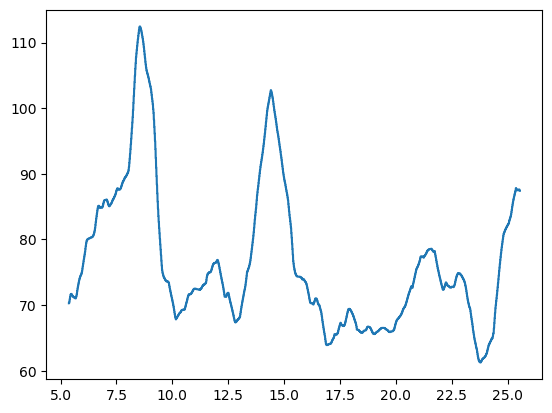

In [12]:
x,y=bvp_time_series[baseline], processed_data[4][baseline]
plt.plot(x, y)
#plt.ylim(int(np.mean(y)), int(np.max(y)))
plt.show() 

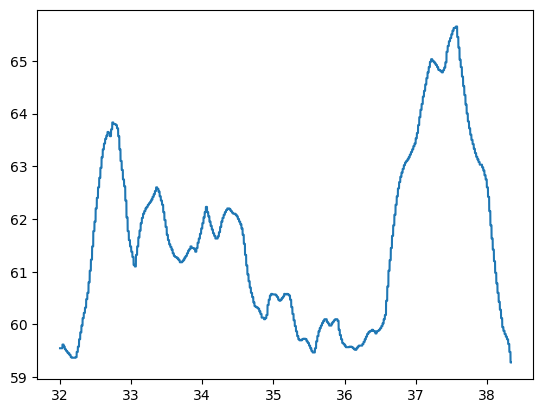

In [13]:
x,y=bvp_time_series[stress], processed_data[4][stress]
plt.plot(x, y)
#plt.ylim(int(np.mean(y)), int(np.max(y)))
plt.show() 

In [153]:
int(np.min(y1)), int(np.max(y1))

(35, 35)

In [45]:
import pickle
with open('./data/WESAD/S2/S2.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')

In [9]:
import numpy as np
with open("./testfile.txt", "a") as file:
    file.write(str(np.array([1,2,3]).tolist())+'\n')